In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import groupby
from time_series_influences.anomaly_detection import eval_anomaly_detector

In [2]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 10
BIGGER_SIZE = 10
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=.5)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=1)
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 3

#### SMD

In [3]:
data_path = Path("./SMD/dataset/")
score_path = Path("./SMD/")
save_path = Path("./good_notation_examples/SMD/")
detectors = ["InfluenceFunction", "IForest", "LSTM", "VAR", "AnomalyTransformer"]
detectors_names = ["Influence Function", "Isolation Forest", "LSTM", "ARIMA/VAR", "Anomaly Transformer"]

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
anomaly_scores_dict, metrics_dict = {}, {}

for fname in os.listdir(data_path):
    if fname.endswith("test.pkl"):
        channel = fname.split("_")[0]
        anomaly_scores_dict[channel] = {}
        ts = np.load(data_path/fname, allow_pickle=True)
        gt = np.load(data_path/f"{channel}_test_label.pkl", allow_pickle=True)
        seqs = [(key, len(list(val))) for key, val in groupby(list(gt))]
        seqs = [(key, sum(s[1] for s in seqs[:i]), len) for i, (key, len) in enumerate(seqs)]
        start_end = [[s[1], s[1] + s[2] - 1] for s in seqs if s[0] == 1]
        seq_len, n_dim = ts.shape
        anomaly_scores_dict[channel].update({"Observed": ts})
        anomaly_scores_dict[channel].update({"Label": gt})
        anomaly_scores_dict[channel].update({"start_end": start_end})

        for i, detector in enumerate(detectors):
            try:
                score_file = score_path/f"{channel}_{detector}Detector_anomaly_scores"
                anomaly_scores = pd.read_pickle(score_file)
                if detector == "InfluenceFunction":
                    anomaly_scores = np.mean(anomaly_scores, 0)
                else:
                    scaler = MinMaxScaler()
                    anomaly_scores = scaler.fit_transform(anomaly_scores.reshape(-1,1)).squeeze()
                anomaly_scores_dict[channel].update({detectors_names[i]: anomaly_scores})
            except FileNotFoundError:
                print(score_file)

SMD/machine-3-7_VARDetector_anomaly_scores
SMD/machine-3-9_VARDetector_anomaly_scores
SMD/machine-2-1_VARDetector_anomaly_scores
SMD/machine-3-10_VARDetector_anomaly_scores
SMD/machine-3-3_VARDetector_anomaly_scores


  0%|                                                    | 0/38 [00:00<?, ?it/s]

precision: 0.372 recall: 0.371 F1: 0.372 AUC: 0.903
precision: 0.332 recall: 0.332 F1: 0.332 AUC: 0.861
precision: 0.162 recall: 0.162 F1: 0.162 AUC: 0.839
precision: 0.098 recall: 0.098 F1: 0.098 AUC: 0.708
precision: 0.030 recall: 0.030 F1: 0.030 AUC: 0.504


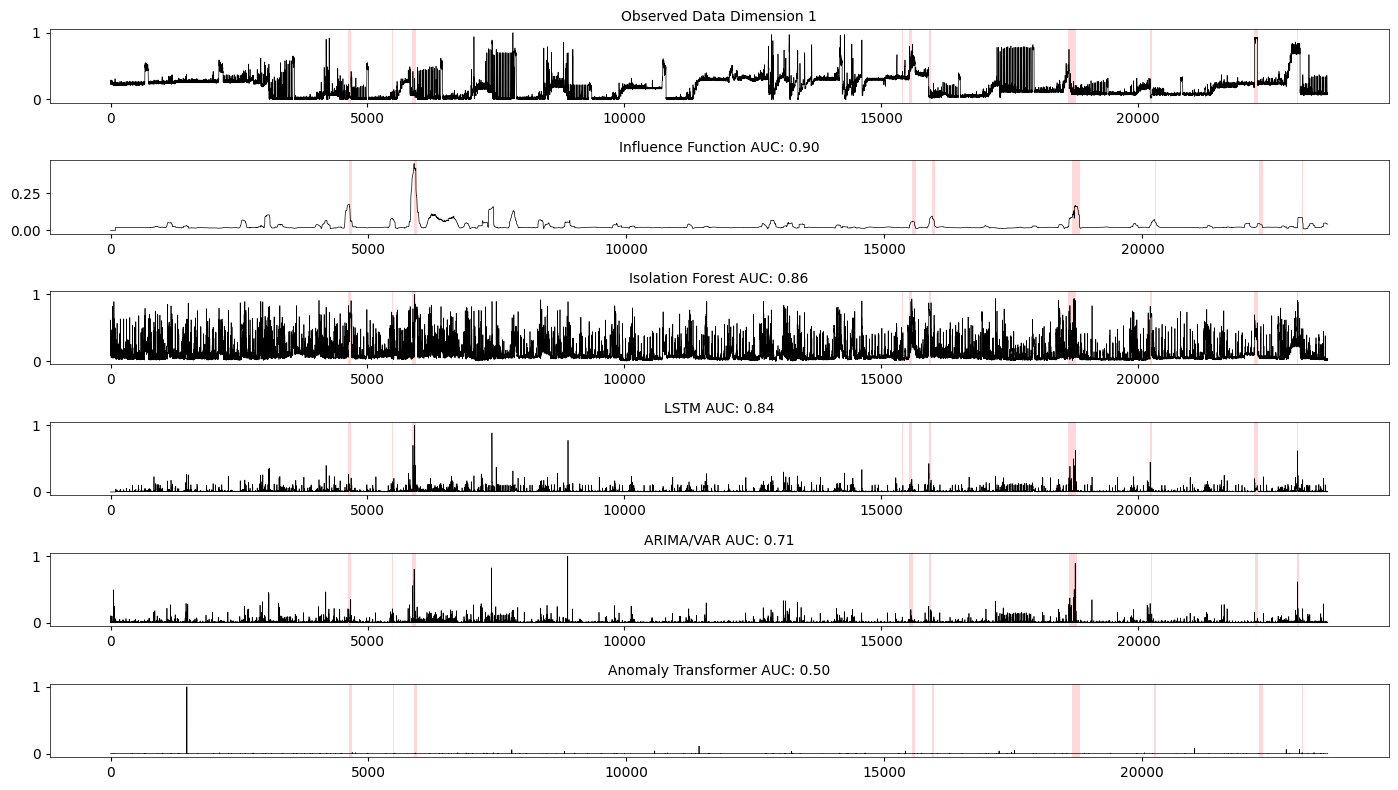

In [49]:
channel = list(anomaly_scores_dict.keys())[18]

for i in tqdm(range(n_dim), total=n_dim):
    fig, axes = plt.subplots(len(detectors)+1, 1, figsize=(14, 8))
    axes[0].plot(anomaly_scores_dict[channel]["Observed"].T[i], color="k", linewidth=0.5)
    axes[0].set_title(f"Observed Data Dimension {i+1}")
    for chunk in anomaly_scores_dict[channel]["start_end"]:
        axes[0].axvspan(chunk[0], chunk[1], facecolor='r', alpha=.15)
    for j in range(len(detectors)):
        anomaly_scores = anomaly_scores_dict[channel][detectors_names[j]]
        gt = anomaly_scores_dict[channel]["Label"]
        contam_ratio = np.sum(gt) / len(gt)
        pred = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)
        _, _, f1, auc = eval_anomaly_detector(gt[:len(pred)], pred, anomaly_scores)
        axes[j+1].plot(anomaly_scores, color="k", linewidth=0.5)
        for chunk in anomaly_scores_dict[channel]["start_end"]:
            axes[j+1].axvspan(chunk[0], chunk[1], facecolor='r', alpha=.15)
        axes[j+1].set_title(f"{detectors_names[j]} AUC: {auc:.2f}")
    plt.tight_layout()
    # plt.savefig(save_path/f"dim_{i}", dpi=100)
    break
    plt.show()

In [ ]:
# selected_channels = [4, 5, 6, 7, 13, 14, 16, 18] 

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 133.75it/s]


precision: 0.454 recall: 0.452 F1: 0.453 AUC: 0.933
precision: 0.223 recall: 0.223 F1: 0.223 AUC: 0.831
precision: 0.315 recall: 0.315 F1: 0.315 AUC: 0.742
precision: 0.152 recall: 0.152 F1: 0.152 AUC: 0.690
precision: 0.038 recall: 0.038 F1: 0.038 AUC: 0.490


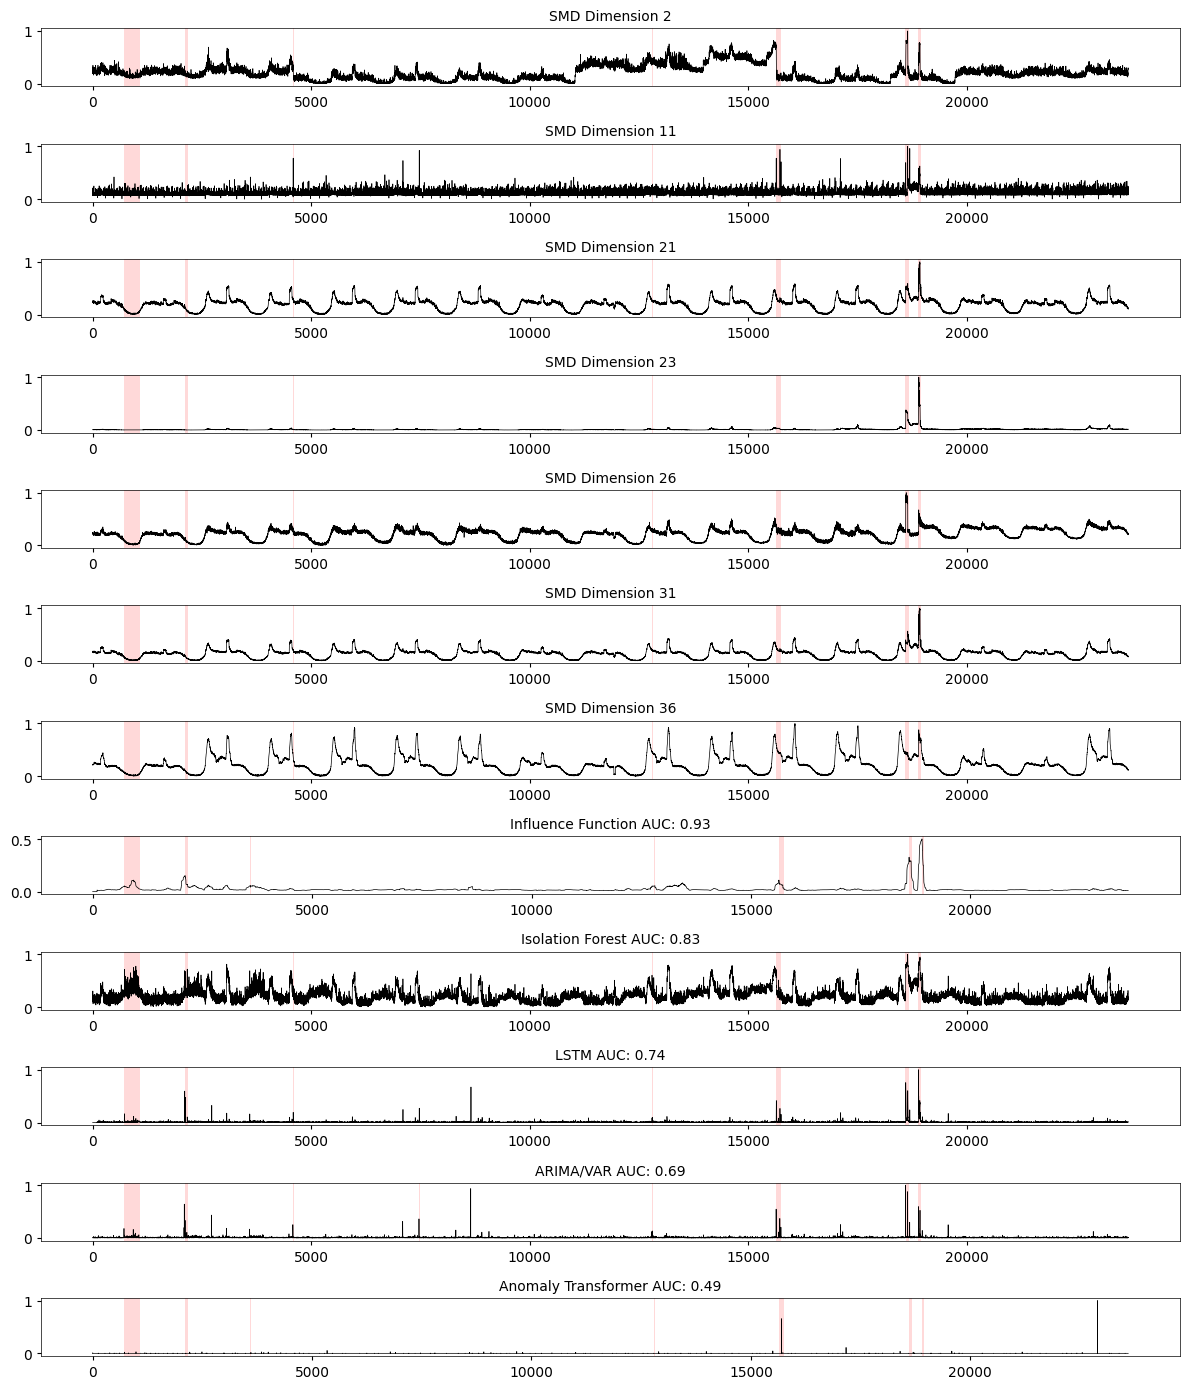

In [64]:
channel = list(anomaly_scores_dict.keys())[16]

selected_dims = [1, 10, 20, 22, 25, 30, 35]

fig, axes = plt.subplots(len(detectors)+7, 1, figsize=(12, 14))
for i, dim_idx in tqdm(enumerate(selected_dims), total=len(selected_dims)):
    axes[i].plot(anomaly_scores_dict[channel]["Observed"].T[dim_idx], color="k", linewidth=0.5)
    axes[i].set_title(f"SMD Dimension {dim_idx+1}")
    for chunk in anomaly_scores_dict[channel]["start_end"]:
        axes[i].axvspan(chunk[0], chunk[1], facecolor='r', alpha=.15)
            
for j in range(len(detectors)):
    anomaly_scores = anomaly_scores_dict[channel][detectors_names[j]]
    gt = anomaly_scores_dict[channel]["Label"]
    contam_ratio = np.sum(gt) / len(gt)
    pred = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)
    _, _, f1, auc = eval_anomaly_detector(gt[:len(pred)], pred, anomaly_scores)
    axes[j+7].plot(anomaly_scores, color="k", linewidth=0.5)
    for chunk in anomaly_scores_dict[channel]["start_end"]:
        axes[j+7].axvspan(chunk[0], chunk[1], facecolor='r', alpha=.15)
    axes[j+7].set_title(f"{detectors_names[j]} AUC: {auc:.2f}")
plt.tight_layout()
# plt.savefig("./plots/smd_good_annotation.png", dpi=200)
# break
plt.show()

#### SMAP

In [67]:
data_path = Path("./SMAP/dataset/")
score_path = Path("./SMAP/")
save_path = Path("./good_notation_examples/SMD/")
detectors = ["InfluenceFunction", "IForest", "LSTM", "ARIMA", "AnomalyTransformer"]
detectors_names = ["Influence Function", "Isolation Forest", "LSTM", "ARIMA/VAR", "Anomaly Transformer"]

In [70]:
anomaly_scores_dict, metrics_dict = {}, {}

for fname in os.listdir(data_path):
    if fname.endswith("test.pkl"):
        channel = fname.split("_")[0]
        anomaly_scores_dict[channel] = {}
        ts = np.load(data_path/fname, allow_pickle=True)
        gt = np.load(data_path/f"{channel}_test_label.pkl", allow_pickle=True)
        seqs = [(key, len(list(val))) for key, val in groupby(list(gt))]
        seqs = [(key, sum(s[1] for s in seqs[:i]), len) for i, (key, len) in enumerate(seqs)]
        start_end = [[s[1], s[1] + s[2] - 1] for s in seqs if s[0] == 1]
        seq_len, n_dim = ts.shape
        anomaly_scores_dict[channel].update({"Observed": ts})
        anomaly_scores_dict[channel].update({"Label": gt})
        anomaly_scores_dict[channel].update({"start_end": start_end})

        for i, detector in enumerate(detectors):
            try:
                score_file = score_path/f"{channel}_{detector}Detector_anomaly_scores"
                anomaly_scores = pd.read_pickle(score_file)
                if detector == "InfluenceFunction":
                    # anomaly_scores = np.mean(anomaly_scores, 0)
                    pass
                else:
                    scaler = MinMaxScaler()
                    anomaly_scores = scaler.fit_transform(anomaly_scores.reshape(-1,1)).squeeze()
                anomaly_scores_dict[channel].update({detectors_names[i]: anomaly_scores})
            except FileNotFoundError:
                print(score_file)

In [111]:
channels = list(anomaly_scores_dict.keys())

  0%|                                                    | 0/25 [00:00<?, ?it/s]

precision: 0.604 recall: 0.597 F1: 0.600 AUC: 0.899
precision: 0.632 recall: 0.366 F1: 0.463 AUC: 0.679
precision: 0.566 recall: 0.530 F1: 0.547 AUC: 0.820
precision: 0.590 recall: 0.590 F1: 0.590 AUC: 0.833
precision: 0.030 recall: 0.030 F1: 0.030 AUC: 0.505


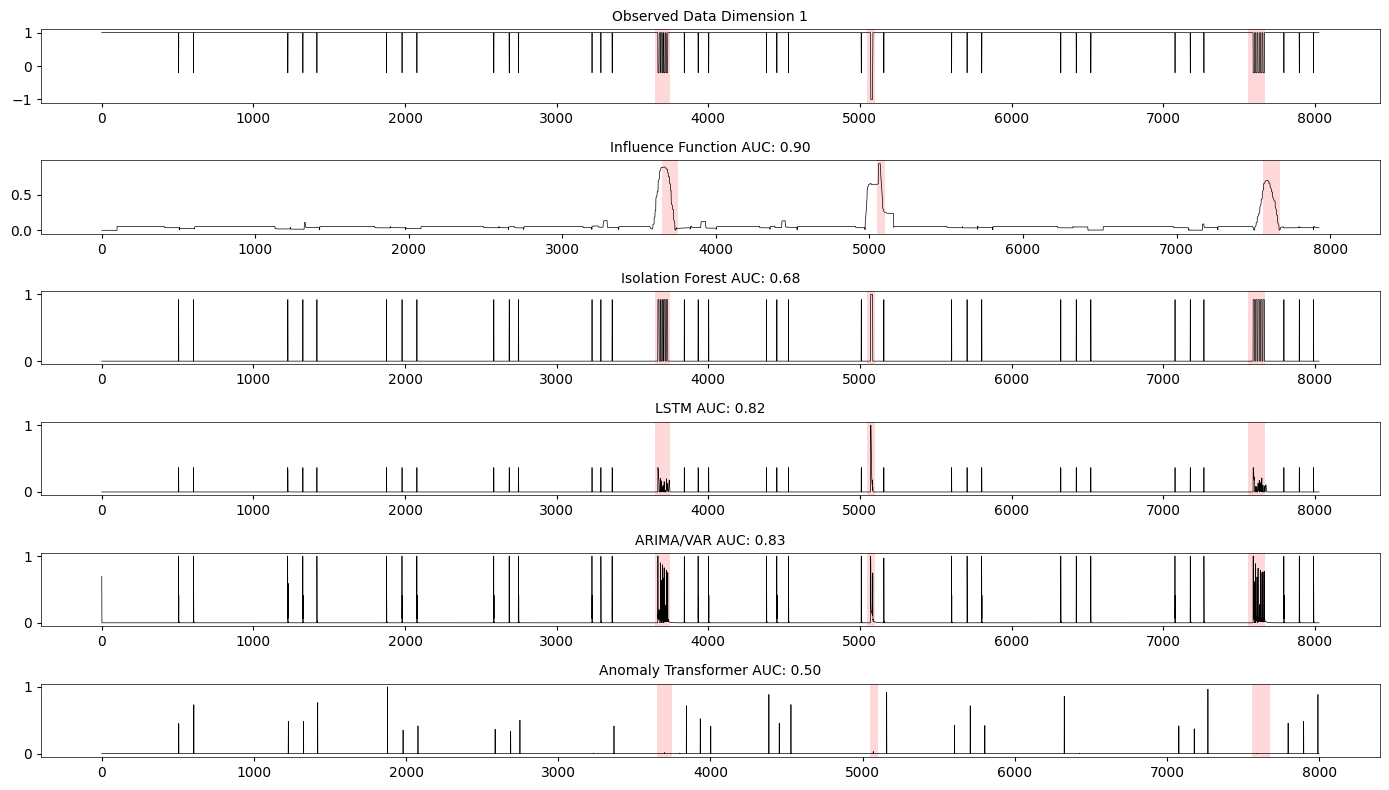

In [116]:
channel = list(anomaly_scores_dict.keys())[23]

for i in tqdm(range(n_dim), total=n_dim):
    fig, axes = plt.subplots(len(detectors)+1, 1, figsize=(14, 8))
    axes[0].plot(anomaly_scores_dict[channel]["Observed"].T[i], color="k", linewidth=0.5)
    axes[0].set_title(f"Observed Data Dimension {i+1}")
    for chunk in anomaly_scores_dict[channel]["start_end"]:
        axes[0].axvspan(chunk[0], chunk[1], facecolor='r', alpha=.15)
    for j in range(len(detectors)):
        anomaly_scores = anomaly_scores_dict[channel][detectors_names[j]]
        gt = anomaly_scores_dict[channel]["Label"]
        contam_ratio = np.sum(gt) / len(gt)
        pred = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)
        _, _, f1, auc = eval_anomaly_detector(gt[:len(pred)], pred, anomaly_scores)
        axes[j+1].plot(anomaly_scores, color="k", linewidth=0.5)
        for chunk in anomaly_scores_dict[channel]["start_end"]:
            axes[j+1].axvspan(chunk[0], chunk[1], facecolor='r', alpha=.15)
        axes[j+1].set_title(f"{detectors_names[j]} AUC: {auc:.2f}")
    plt.tight_layout()
    # plt.savefig(save_path/f"dim_{i}", dpi=100)
    break
    plt.show()

In [109]:
selected_channels = [0, 23, 24] 

precision: 0.392 recall: 0.388 F1: 0.390 AUC: 0.987
precision: 0.604 recall: 0.597 F1: 0.600 AUC: 0.899
precision: 0.676 recall: 0.667 F1: 0.672 AUC: 0.891
precision: 0.000 recall: 0.000 F1: 0.000 AUC: 0.116
precision: 0.632 recall: 0.366 F1: 0.463 AUC: 0.679
precision: 0.537 recall: 0.536 F1: 0.536 AUC: 0.782
precision: 0.017 recall: 0.017 F1: 0.017 AUC: 0.561
precision: 0.566 recall: 0.530 F1: 0.547 AUC: 0.820
precision: 0.085 recall: 0.085 F1: 0.085 AUC: 0.387
precision: 0.025 recall: 0.025 F1: 0.025 AUC: 0.333
precision: 0.590 recall: 0.590 F1: 0.590 AUC: 0.833
precision: 0.078 recall: 0.078 F1: 0.078 AUC: 0.418
precision: 0.000 recall: 0.000 F1: 0.000 AUC: 0.480
precision: 0.030 recall: 0.030 F1: 0.030 AUC: 0.505
precision: 0.070 recall: 0.047 F1: 0.056 AUC: 0.503


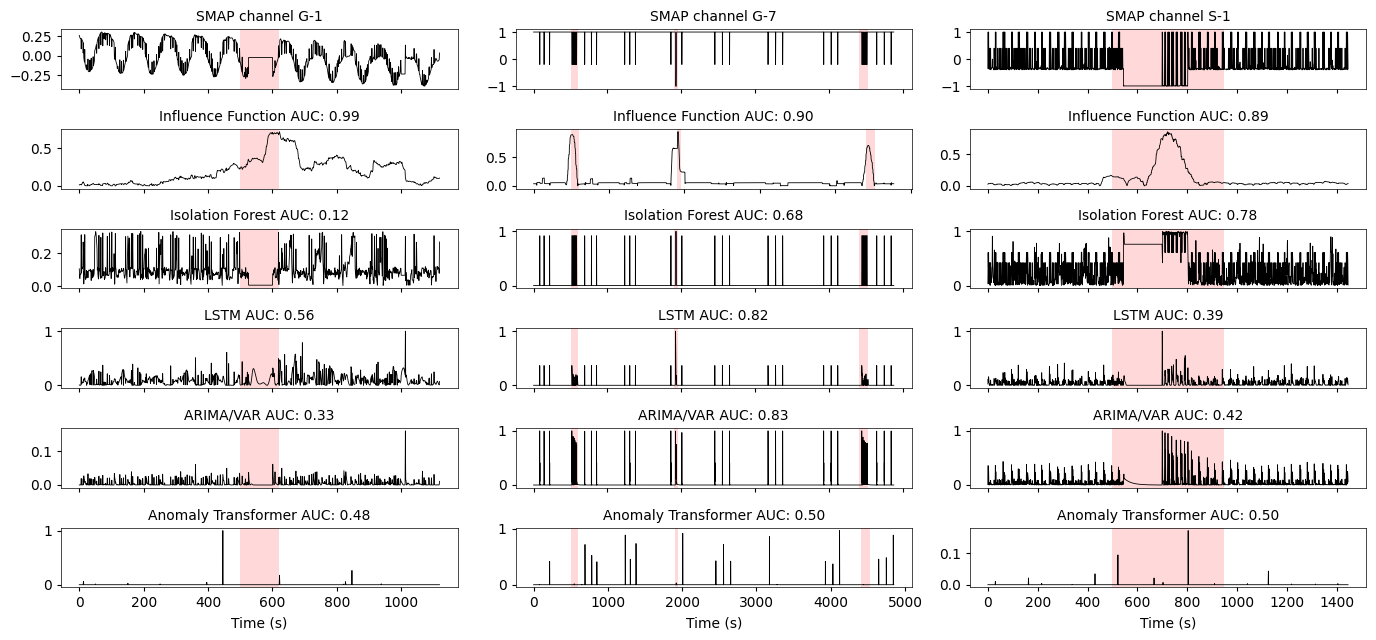

In [148]:
offset = 500
block_len = 100

fig, axes = plt.subplots(len(detectors)+1, len(selected_channels), figsize=(14, 6.5))

for i, dim in enumerate([0]):
    for j in range(len(selected_channels)):
        start_end = anomaly_scores_dict[channels[selected_channels[j]]]["start_end"]
        start, end = np.array(start_end).min(), np.array(start_end).max()
        obs = anomaly_scores_dict[channels[selected_channels[j]]]["Observed"].T[dim][start-offset:end+offset]
        axes[i,j].plot(obs, color="k", linewidth=.6)
        axes[i,j].tick_params(labelbottom=False)    
        axes[-1,j].set_xlabel("Time (s)")
        axes[0,j].set_title(f"SMAP channel {channels[selected_channels[j]]}")
        if len(start_end) == 1:
            for chunk in start_end:
                axes[i,j].axvspan(offset, end-start+offset, facecolor='r', alpha=.15)
        else:
            for t, chunk in enumerate(start_end):
                axes[i,j].axvspan(offset+(start_end[t][0]-start_end[0][0]), 
                                      offset+(start_end[t][0]-start_end[0][0]) + (start_end[t][1]-start_end[t][0]), 
                                      facecolor='r', alpha=.15)

for i in range(len(detectors)):
    for j in range(len(selected_channels)):
        start_end = anomaly_scores_dict[channels[selected_channels[j]]]["start_end"]
        start, end = np.array(start_end).min(), np.array(start_end).max()
        scores = anomaly_scores_dict[channels[selected_channels[j]]][detectors_names[i]].T[start-offset:end+offset]
        axes[i+1,j].plot(scores, color="k", linewidth=.6)
        axes[i,j].tick_params(labelbottom=False)  
        if len(start_end) == 1:
            for chunk in start_end:
                axes[i+1,j].axvspan(offset, end-start+offset, facecolor='r', alpha=.15)
        else:
            for t, chunk in enumerate(start_end):
                axes[i+1,j].axvspan(offset+(start_end[t][0]-start_end[0][0]), 
                                      offset+(start_end[t][0]-start_end[0][0]) + (start_end[t][1]-start_end[t][0]), 
                                      facecolor='r', alpha=.15)

        anomaly_scores = anomaly_scores_dict[channels[selected_channels[j]]][detectors_names[i]]
        gt = anomaly_scores_dict[channels[selected_channels[j]]]["Label"]
        contam_ratio = np.sum(gt) / len(gt)
        pred = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)
        _, _, f1, auc = eval_anomaly_detector(gt[:len(pred)], pred, anomaly_scores)
        axes[i+1,j].set_title(f"{detectors_names[i]} AUC: {auc:.2f}", fontsize=10)
        # axes[i+1,j].set_ylim(0, 1)
        # axes[i,j].set_yticks(axes[i,j].get_yticks(), axes[i,j].get_yticklabels(), ha='right')
        
plt.tight_layout()
# plt.savefig("./plots/smap_good_example.png", dpi=200)

#### MSL



In [149]:
data_path = Path("./MSL/dataset/")
score_path = Path("./MSL/")
save_path = Path("./good_notation_examples/MSL/")
detectors = ["InfluenceFunction", "IForest", "LSTM", "ARIMA", "AnomalyTransformer"]
detectors_names = ["Influence Function", "Isolation Forest", "LSTM", "ARIMA/VAR", "Anomaly Transformer"]

In [150]:
anomaly_scores_dict, metrics_dict = {}, {}

for fname in os.listdir(data_path):
    if fname.endswith("test.pkl"):
        channel = fname.split("_")[0]
        anomaly_scores_dict[channel] = {}
        ts = np.load(data_path/fname, allow_pickle=True)
        gt = np.load(data_path/f"{channel}_test_label.pkl", allow_pickle=True)
        seqs = [(key, len(list(val))) for key, val in groupby(list(gt))]
        seqs = [(key, sum(s[1] for s in seqs[:i]), len) for i, (key, len) in enumerate(seqs)]
        start_end = [[s[1], s[1] + s[2] - 1] for s in seqs if s[0] == 1]
        seq_len, n_dim = ts.shape
        anomaly_scores_dict[channel].update({"Observed": ts})
        anomaly_scores_dict[channel].update({"Label": gt})
        anomaly_scores_dict[channel].update({"start_end": start_end})

        for i, detector in enumerate(detectors):
            try:
                score_file = score_path/f"{channel}_{detector}Detector_anomaly_scores"
                anomaly_scores = pd.read_pickle(score_file)
                if detector == "InfluenceFunction":
                    # anomaly_scores = np.mean(anomaly_scores, 0)
                    pass
                else:
                    scaler = MinMaxScaler()
                    anomaly_scores = scaler.fit_transform(anomaly_scores.reshape(-1,1)).squeeze()
                anomaly_scores_dict[channel].update({detectors_names[i]: anomaly_scores})
            except FileNotFoundError:
                print(score_file)

In [151]:
channels = list(anomaly_scores_dict.keys())

  0%|                                                    | 0/55 [00:00<?, ?it/s]

precision: 0.467 recall: 0.551 F1: 0.506 AUC: 0.720
precision: 0.225 recall: 0.203 F1: 0.214 AUC: 0.544
precision: 0.212 recall: 0.212 F1: 0.212 AUC: 0.472
precision: 0.212 recall: 0.212 F1: 0.212 AUC: 0.499
precision: 0.337 recall: 0.129 F1: 0.186 AUC: 0.535


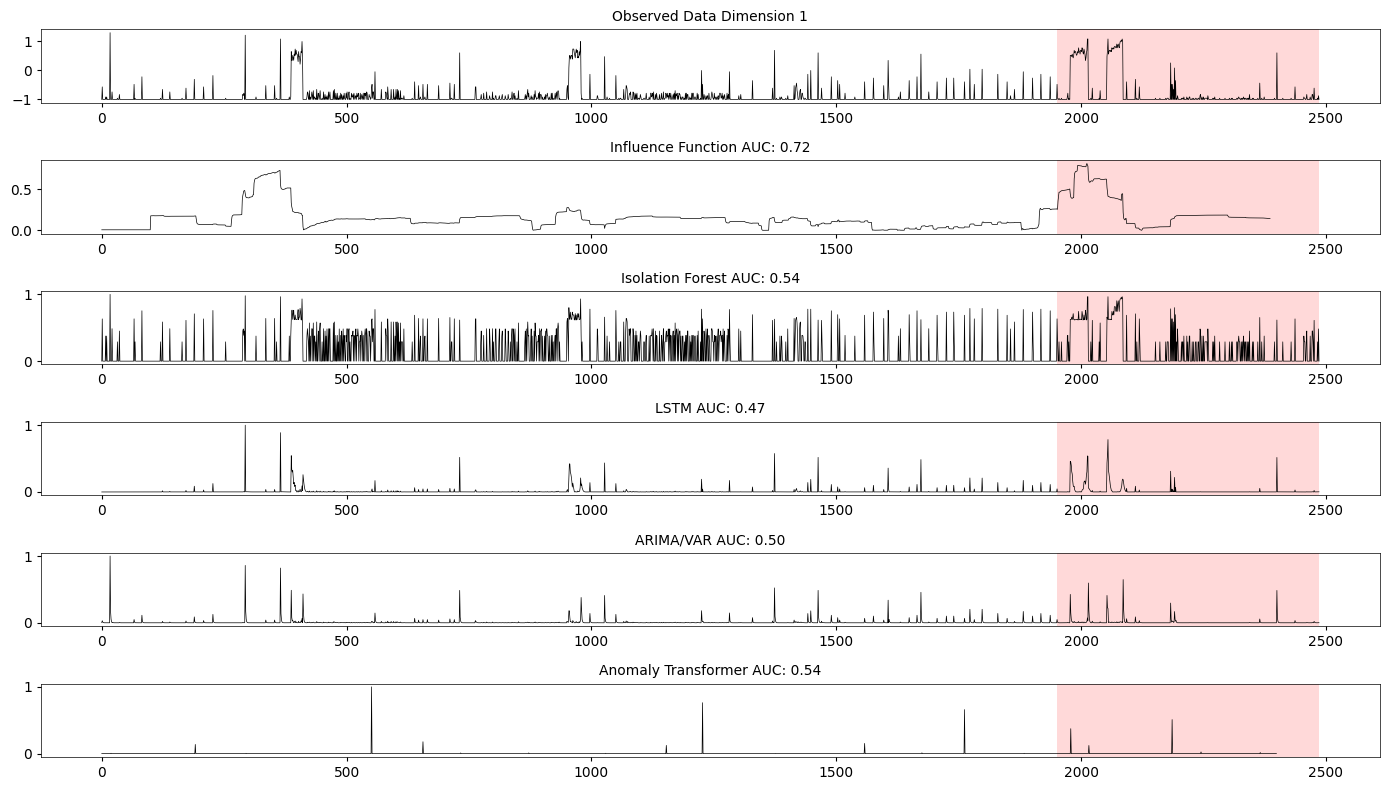

In [182]:
channel = list(anomaly_scores_dict.keys())[0]

for i in tqdm(range(n_dim), total=n_dim):
    fig, axes = plt.subplots(len(detectors)+1, 1, figsize=(14, 8))
    axes[0].plot(anomaly_scores_dict[channel]["Observed"].T[i], color="k", linewidth=0.5)
    axes[0].set_title(f"Observed Data Dimension {i+1}")
    for chunk in anomaly_scores_dict[channel]["start_end"]:
        axes[0].axvspan(chunk[0], chunk[1], facecolor='r', alpha=.15)
    for j in range(len(detectors)):
        anomaly_scores = anomaly_scores_dict[channel][detectors_names[j]]
        gt = anomaly_scores_dict[channel]["Label"]
        contam_ratio = np.sum(gt) / len(gt)
        pred = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)
        _, _, f1, auc = eval_anomaly_detector(gt[:len(pred)], pred, anomaly_scores)
        axes[j+1].plot(anomaly_scores, color="k", linewidth=0.5)
        for chunk in anomaly_scores_dict[channel]["start_end"]:
            axes[j+1].axvspan(chunk[0], chunk[1], facecolor='r', alpha=.15)
        axes[j+1].set_title(f"{detectors_names[j]} AUC: {auc:.2f}")
    plt.tight_layout()
    # plt.savefig(save_path/f"dim_{i}", dpi=100)
    break
    plt.show()

In [185]:
# selected_channels = [5, 7, 10, 20] 
selected_channels = [5, 7, 20] 

precision: 0.724 recall: 0.694 F1: 0.709 AUC: 0.886
precision: 0.793 recall: 0.772 F1: 0.782 AUC: 0.885
precision: 0.533 recall: 0.522 F1: 0.527 AUC: 0.764
precision: 0.091 recall: 0.091 F1: 0.091 AUC: 0.569
precision: 0.439 recall: 0.439 F1: 0.439 AUC: 0.792
precision: 0.143 recall: 0.142 F1: 0.142 AUC: 0.657
precision: 0.223 recall: 0.223 F1: 0.223 AUC: 0.733
precision: 0.285 recall: 0.285 F1: 0.285 AUC: 0.737
precision: 0.118 recall: 0.118 F1: 0.118 AUC: 0.587
precision: 0.132 recall: 0.132 F1: 0.132 AUC: 0.558
precision: 0.206 recall: 0.206 F1: 0.206 AUC: 0.748
precision: 0.104 recall: 0.104 F1: 0.104 AUC: 0.657
precision: 0.008 recall: 0.008 F1: 0.008 AUC: 0.378
precision: 0.029 recall: 0.022 F1: 0.025 AUC: 0.486
precision: 0.073 recall: 0.054 F1: 0.062 AUC: 0.495


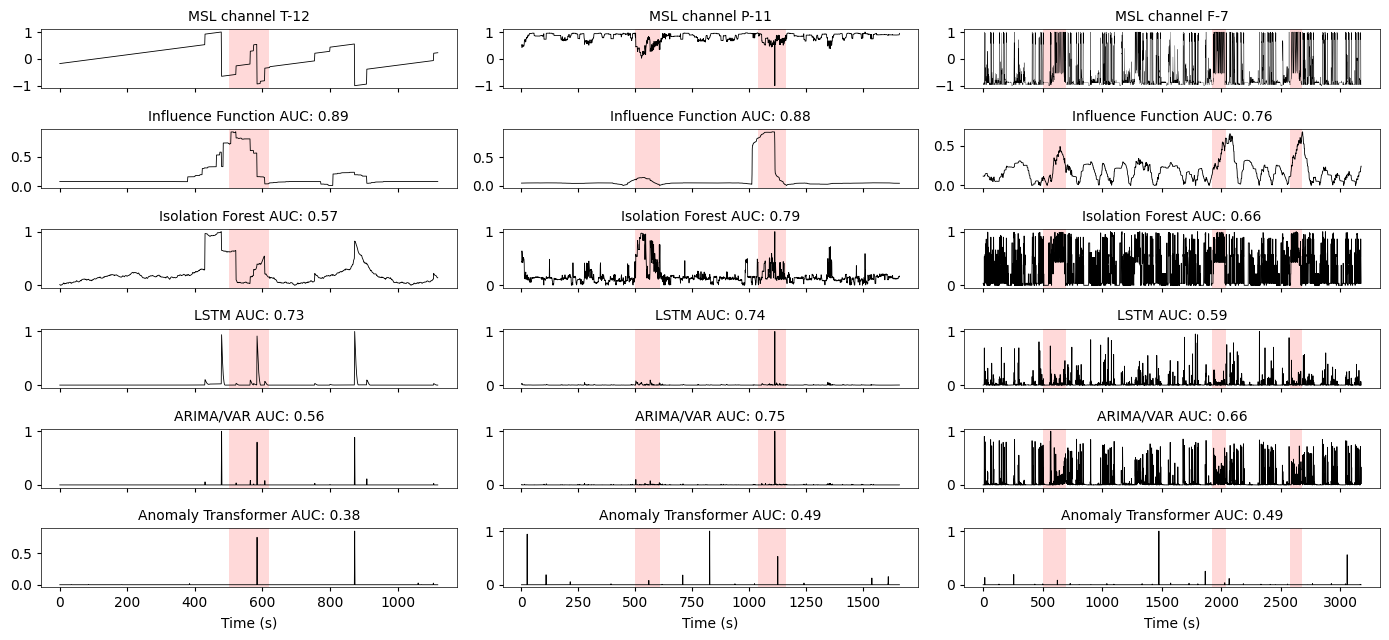

In [189]:
offset = 500
block_len = 100

fig, axes = plt.subplots(len(detectors)+1, len(selected_channels), figsize=(14, 6.5))

for i, dim in enumerate([0]):
    for j in range(len(selected_channels)):
        start_end = anomaly_scores_dict[channels[selected_channels[j]]]["start_end"]
        start, end = np.array(start_end).min(), np.array(start_end).max()
        obs = anomaly_scores_dict[channels[selected_channels[j]]]["Observed"].T[dim][start-offset:end+offset]
        if j != 2:
            axes[i,j].plot(obs, color="k", linewidth=.6)
        else:
            axes[i,j].plot(obs, color="k", linewidth=.2)
        axes[i,j].tick_params(labelbottom=False)    
        axes[-1,j].set_xlabel("Time (s)")
        axes[0,j].set_title(f"MSL channel {channels[selected_channels[j]]}")
        if len(start_end) == 1:
            for chunk in start_end:
                axes[i,j].axvspan(offset, end-start+offset, facecolor='r', alpha=.15)
        else:
            for t, chunk in enumerate(start_end):
                axes[i,j].axvspan(offset+(start_end[t][0]-start_end[0][0]), 
                                      offset+(start_end[t][0]-start_end[0][0]) + (start_end[t][1]-start_end[t][0]), 
                                      facecolor='r', alpha=.15)

for i in range(len(detectors)):
    for j in range(len(selected_channels)):
        start_end = anomaly_scores_dict[channels[selected_channels[j]]]["start_end"]
        start, end = np.array(start_end).min(), np.array(start_end).max()
        scores = anomaly_scores_dict[channels[selected_channels[j]]][detectors_names[i]].T[start-offset:end+offset]
        axes[i+1,j].plot(scores, color="k", linewidth=.6)
        axes[i,j].tick_params(labelbottom=False)  
        if len(start_end) == 1:
            for chunk in start_end:
                axes[i+1,j].axvspan(offset, end-start+offset, facecolor='r', alpha=.15)
        else:
            for t, chunk in enumerate(start_end):
                axes[i+1,j].axvspan(offset+(start_end[t][0]-start_end[0][0]), 
                                      offset+(start_end[t][0]-start_end[0][0]) + (start_end[t][1]-start_end[t][0]), 
                                      facecolor='r', alpha=.15)

        anomaly_scores = anomaly_scores_dict[channels[selected_channels[j]]][detectors_names[i]]
        gt = anomaly_scores_dict[channels[selected_channels[j]]]["Label"]
        contam_ratio = np.sum(gt) / len(gt)
        pred = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)
        _, _, f1, auc = eval_anomaly_detector(gt[:len(pred)], pred, anomaly_scores)
        axes[i+1,j].set_title(f"{detectors_names[i]} AUC: {auc:.2f}", fontsize=10)
        # axes[i+1,j].set_ylim(0, 1)
        # axes[i,j].set_yticks(axes[i,j].get_yticks(), axes[i,j].get_yticklabels(), ha='right')
        
plt.tight_layout()
plt.savefig("./plots/msl_good_example.png", dpi=200)